In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [3]:
def trap(w_k, A, delta_t, n):
    '''
    A function that returns the k+1 th w vector 
    
    Parameters
    ----------
    w_k : array_like
        (2n-2) x (1) vector. Represents the displacement u and du/dt at t_k 
        [[u_k]
         [v_k]]
    A : array_like
        (2n-2) x (2n-2) matrix. Satisfies wdot = A @ w 
        Has the form  
        [[0 I]
        [M 0]]
        
    delta_t : double 
        Time step
    n : double 
        Vector u has n + 1 elements. Vector w has 2N + 2 elements.
    Output
    ------
    w_kplusone : array_like 
    '''
    
    # take off 1st, (n + 1)th, (n + 2)th, and last element 
    w_k = np.delete(w_k, [0, n, n+1, 2*n + 1])

    # Set up and solve for w_k+1    
    first = np.identity(A.shape[0]) - (0.5*delta_t * A)
    second = (np.identity(A.shape[0]) + delta_t/2 * A) @ w_k
    w_kplusone = np.linalg.solve(first, second)
    
    # The returned w_kplusone is NOT w_list[k] because it is missing boundary conditions. Add boundary conditions 
    w_kplusone = np.insert(w_kplusone, [0, n-1, n-1, 2*(n-1)], [0])
    
    return w_kplusone

In [4]:
def wave_approximation(a, b, c, n, delta_t, T, u_0, v_0, nu = 0):
    '''
    Solves the IBVP wave equation problem and returns vector w at t = T 
    
    Parameters
    ----------
    a : double
        lower bound 
    b : double
        upper bound 
    c : double 
        speed of the wave 
    n : double 
        finess of the spacial mesh 
    delta_t : double
        time step size (in seconds)
    T : double 
        amount of time the wave is simulated for in seconds 
    u_0 : array_like
        (n+1) x (1) vector that represents the initial condition of u 
    v_0 : array_like  
        (n+1) x (1) vector that represents the initial condition of du/dt
    nu : double 
        dampening term 
    Output
    ------
    u_final_position : array_like 
        (n+1) x (1) vector. u at t = T
        [[u]
         [v]]
    x_values : array_like
        (n+1) x (1) vector that represents the discretized x domain. 
        
    '''
    dx = (b-a)/n
    x_values = np.arange(a, b + dx/2, dx)
    t_values = np.arange(0, T + delta_t/2, delta_t)
    delta_x = x_values[1] - x_values[0]
    
    n = len(x_values) - 1 # len(x_values) is "n + 1"

       
    # initialize w_list that stores all w vectors  
    w_list = np.zeros([len(t_values), 2 * (n + 1)])
    # initial condition 
    w_initial = np.block([u_0, v_0])
    w_list[0] = w_initial 
    
    
    # Define matrix A
    M = (c**2/(delta_x**2))*(np.diag(-2*np.ones(n - 1), k=0)+np.diag(1*np.ones(n-2),k=1)+np.diag(1*np.ones(n-2),k=-1))
    zeros = np.zeros([n-1, n-1])
    identity = np.eye(n - 1)
    bottomleft = M
    A = np.block([[zeros, identity], [M, -1*nu*identity]])

    for k in range(len(t_values)-1):
        w_k = w_list[k]
        w_kplusone = trap(w_k, A, delta_t, n)
        w_list[k + 1] = w_kplusone
    
    u_final_position = w_list[-1][0: n+1]
    
    return u_final_position, x_values

### Method Verification

A well known solution to the wave equation is the standing wave: 

$u_{\text {standing wave}}(x, t) = \sin(kx-\omega t) + \sin(kx + \omega t)$. 

This solution also satisfies the "fixed-ends" boundary condition. We verified the validity of our numerical method by plotting our approximated solution against this known solution. 

In [5]:
def u_e(t, a, b, c, n):
    '''
    Returns the true value of the displacement at time t 
    
    Parameters
    ----------
    t : double 
        time 
    a : double 
        lower bound 
    b : double 
        upper bound 
    c : double 
        speed of wave 
    n : double 
        finess of the mesh
    Output
    ------
    u_exact : array_like
        (n+1) x (1) vector representing the displacements at time t
    '''
    dx = (b-a)/n
    x = np.arange(a, b + dx/2, dx) 
    
    k = np.pi/(b-a) 
    omega = c*k
    u_exact = np.sin(k*x - omega*t) + np.sin(k*x + omega*t)
    return u_exact

def v_e(t, a, b, c, n):
    '''
    Returns the true value of du/dt at time t 
    
    Parameters
    ----------
    t : double 
        time 
    a : double 
        lower bound 
    b : double 
        upper bound 
    c : double 
        speed of wave 
    n : double 
        finess of the mesh
    Output
    ------
    v_exact : array_like
        (n+1) x (1) vector representing the displacements at time t
    '''
    dx = (b-a)/n
    x = np.arange(a, b + dx/2, dx) 
    k = np.pi/(b-a)
    omega = c*k
    v_exact = -omega*np.cos(k*x - omega*t) + omega*np.cos(k*x + omega*t)
    
    return v_exact

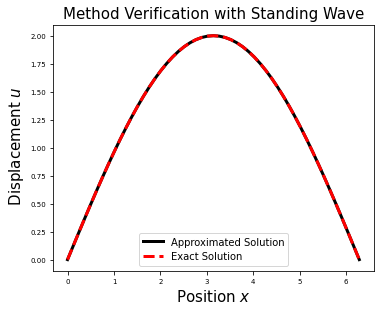

In [6]:
import matplotlib.pyplot as plt

a = 0
b = 2*np.pi
c = 5
n = 50
delta_t= 1e-5
T = 1e-2
t_initial = 0

u_initial = u_e(t_initial, a, b, c, n)
v_initial = v_e(t_initial, a, b, c, n)

u_final, x_list = wave_approximation(a, b, c, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(10, 8), tight_layout=True)

ax1 = fig.add_subplot(221)
ax1.plot(x_list, u_final, 'k-', label='Approximated Solution', linewidth=3)
ax1.plot(x_list, u_e(T, a, b, c, n), 'r--', label='Exact Solution', linewidth=3)
ax1.set_xlabel('Position $x$',fontsize=15)
ax1.set_ylabel(' Displacement $u$',fontsize=15)
ax1.set_title('Method Verification with Standing Wave',fontsize=15)
plt.setp(ax1.get_xticklabels(), fontsize=7)
plt.setp(ax1.get_yticklabels(), fontsize=7)
ax1.legend(prop={'size': 10})

### Generate Error Plots

In [7]:
def wave_error(u_exact_final, u_approx_final):
    '''
    Parameters
    ----------
    u_exact_final : array_like 
        
    u_final : array_like
        
    Output 
    ------
    err : double_like
    '''
    
    e = u_approx_final - u_exact_final
    err = np.linalg.norm(e)/np.linalg.norm(u_exact_final)
                         
    return err

### Generate Spacial Error

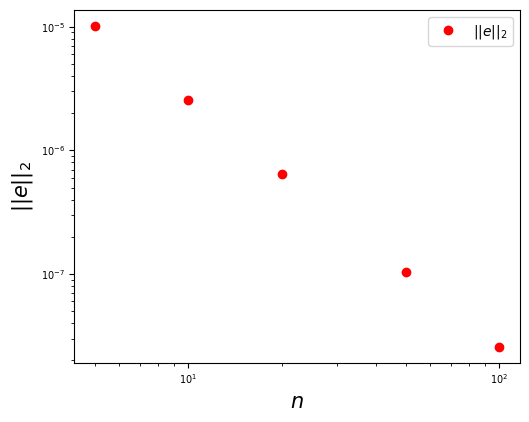

In [13]:
import matplotlib.pyplot as plt

# Parameters 
a = 0
b = 2*np.pi
c = 5
delta_t= 1e-5
T = 1e-2
t_initial = 0

plt.style.use('default')

n_list = [5, 10, 20, 50, 100]
delta_x_list = []
err_list = []

for n in n_list:
    u_initial = u_e(t_initial, a, b, c, n)
    v_initial = v_e(t_initial, a, b, c, n)
    u_final, x_list = wave_approximation(a, b, c, n, delta_t, T, u_initial, v_initial)
    error = wave_error(u_e(T, a, b, c, n), u_final)
    err_list.append(error)
    delta_x = x_list[1] - x_list[0]
    delta_x_list.append(delta_x)
    
fig2 = plt.figure(figsize=(10, 8), tight_layout=True)
ax = fig2.add_subplot(221)
ax.plot(n_list, err_list, 'ro', label='$||e||_2$',linewidth=3)
ax.set_xlabel('$n$', fontsize=15)
ax.set_ylabel('$||e||_2$',fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10, 100])
plt.setp(ax.get_xticklabels(), fontsize=7)
plt.setp(ax.get_yticklabels(), fontsize=7)
ax.legend(prop={'size': 10})

### Generate Temporal Error

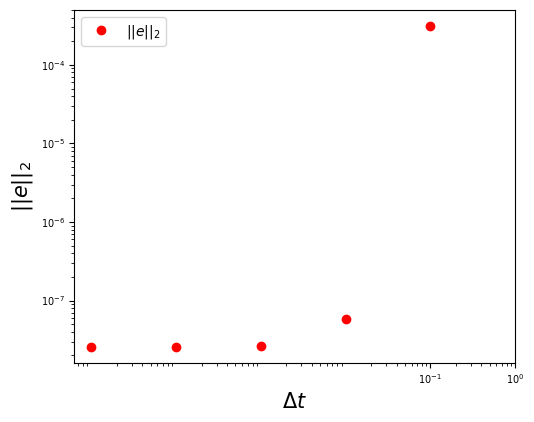

In [17]:
import matplotlib.pyplot as plt

# Parameters  
a = 0
b = 2*np.pi
c = 5
delta_t= 1e-5
T = 1e-2
t_initial = 0

plt.style.use('default')

delta_t_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
err_list = []

u_initial = u_e(t_initial, a, b, c, n)
v_initial = v_e(t_initial, a, b, c, n)
    
for delta_t in delta_t_list:
    u_final, x_list = wave_approximation(a, b, c, n, delta_t, T, u_initial, v_initial)
    error = wave_error(u_e(T, a, b, c, n), u_final)
    err_list.append(error)

fig2 = plt.figure(figsize=(10, 8), tight_layout=True)
ax = fig2.add_subplot(221)
ax.plot(delta_t_list, err_list, 'ro', label='$||e||_2$',linewidth=3)
ax.set_xlabel('$\Delta t$',fontsize=15)
ax.set_ylabel('$||e||_2$',fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.1, 1])
plt.setp(ax.get_xticklabels(), fontsize=7)
plt.setp(ax.get_yticklabels(), fontsize=7)
ax.legend(prop={'size': 10})

### Now We Model the Violin Strings

In [18]:
def initial_wave_conditions(a, b, max_displacement):
    '''
    Returns the initial displacement of a string plucked in the middle. So it is u(x, t) at t = 0. 
    
    Parameters
    ----------
    a : double 
        lower bound 
    b : double 
        upper bound 
    max_displacement : double 
        displacement representing the pluck 
    Output
    ------
    u_0 : array_like 
        (n+1) x (1) array of displacement values 
    '''
    dx = (b-a)/n
    x_list = np.arange(a, b + dx/2, dx) 
    
    string_length = x_list[-1] - x_list[0] 
    dx = x_list[1] - x_list[0]
    
    slope = max_displacement / (string_length/2)
    
    index_middle = int(len(x_list) / 2)
    u_0 = np.zeros(len(x_list))
    for i in range(0, len(x_list)):
        if i < index_middle:
            u_0[i] = u_0[0] + slope * (x_list[i] - x_list[0]) 
            
        else:
            u_0[i] = u_0[0] + slope * (x_list[-1] - x_list[i])

    return u_0 

In [22]:
# Violin string parameters 

c_A = np.sqrt(47.45/(1.28e-3))
c_D = np.sqrt(55.5/(0.67e-3))
c_E = np.sqrt(81.05/(0.43e-3))

a_stringA_noteA = 0
a_stringA_noteB = 0
a_stringA_noteC = 0
a_stringA_noteD = 0

a_stringD_noteG = 0
a_stringE_noteE = 0
a_stringE_noteF = 0
a_stringE_noteG = 0

b_stringA_noteA = 328e-3
b_stringA_noteB = 292.2e-3
b_stringA_noteC = 275.8e-3
b_stringA_noteD = 245.7e-3

b_stringD_noteG = 245.7e-3

b_stringE_noteE = 328e-3
b_stringE_noteF = 309.6e-3
b_stringE_noteG = 275.8e-3

### Generate Plots of Plucked String (No Damping)

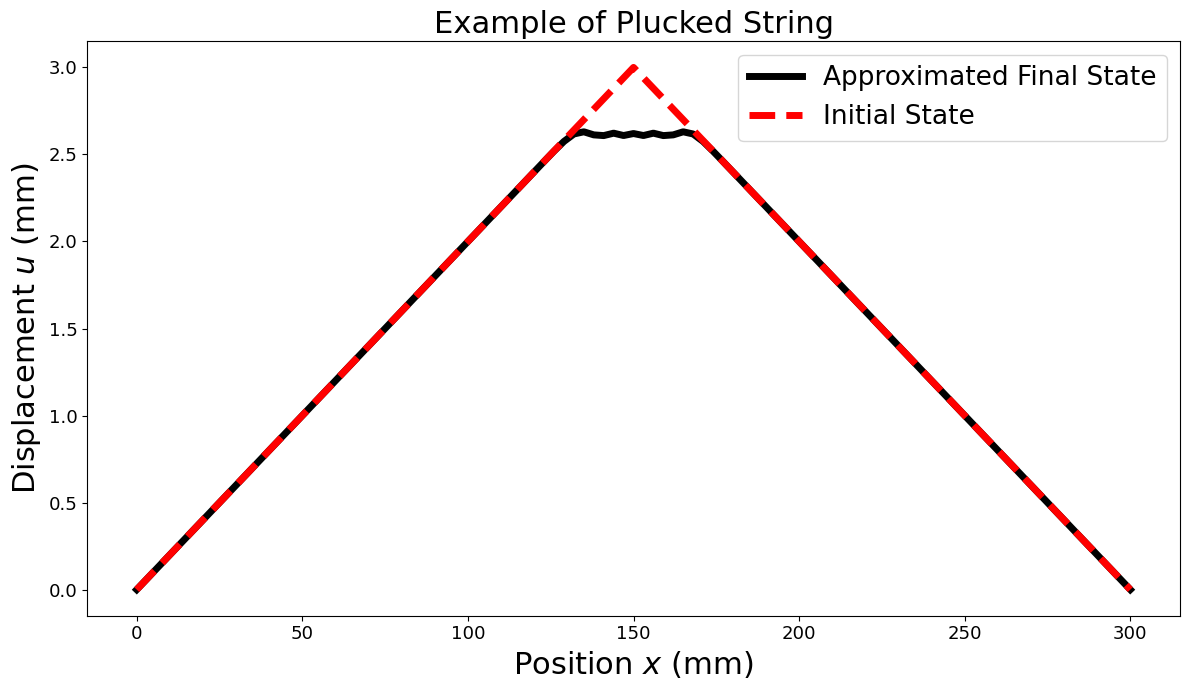

In [23]:
a = 0
b = 300
c = c_A
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a, b, max_displacement)
v_initial = np.zeros(len(u_initial))

u_final, x_list = wave_approximation(a, b, c, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.plot(x_list, u_final, 'k-', label='Approximated Final State', linewidth = 5)
ax1.plot(x_list, u_initial, 'r--', label='Initial State', linewidth = 5)
ax1.set_xlabel('Position $x$ (mm)', fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
ax1.set_title('Example of Plucked String',fontsize=22)
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

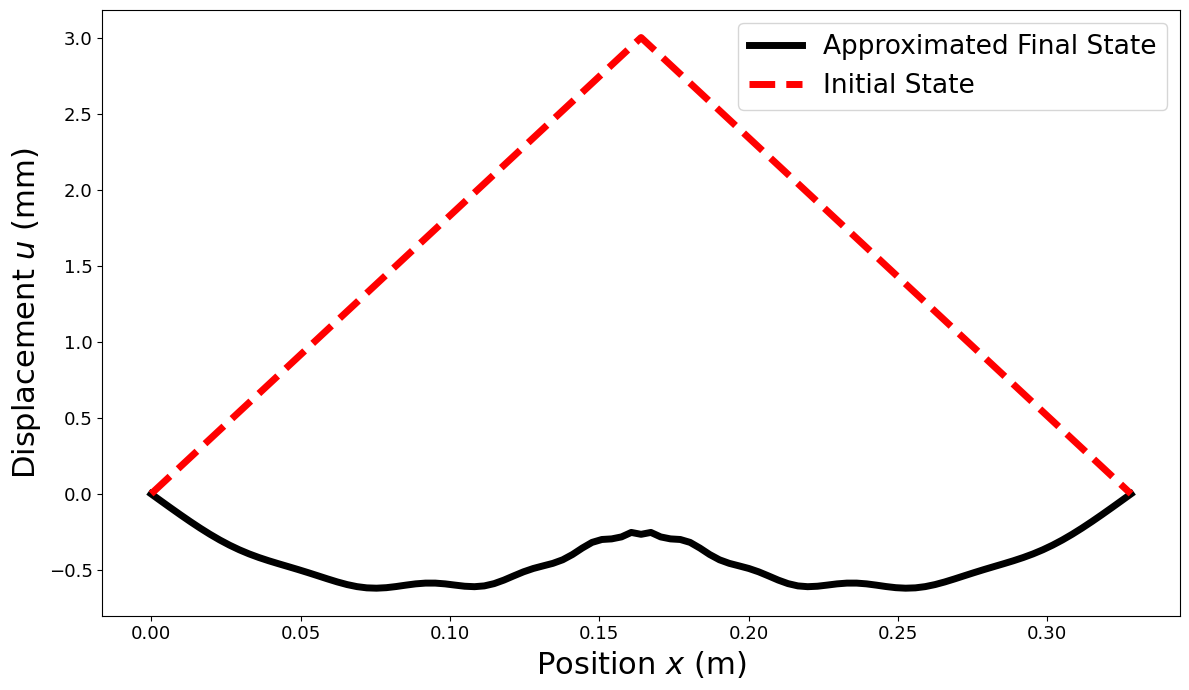

In [24]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringA_noteA, b_stringA_noteA, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringA_noteA, x_stringA_noteA = wave_approximation(a_stringA_noteA, b_stringA_noteA, c_A, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringA_noteA, w_stringA_noteA, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringA_noteA, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note A on String A')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

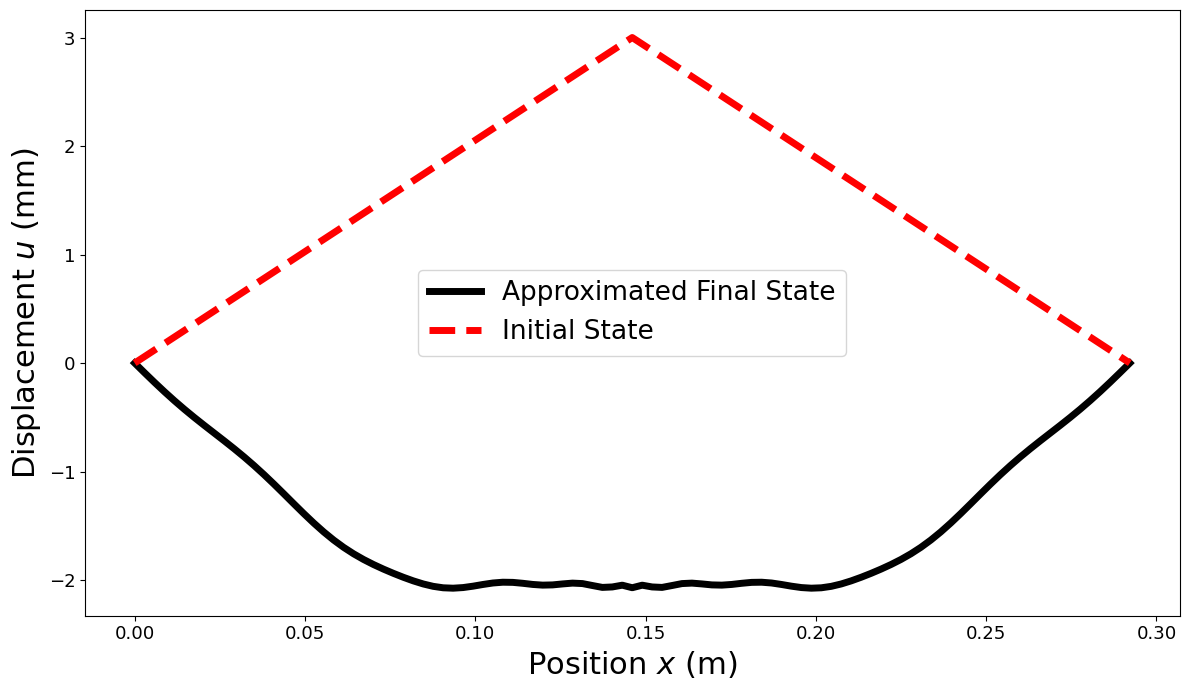

In [25]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringA_noteB, b_stringA_noteB, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringA_noteB, x_stringA_noteB = wave_approximation(a_stringA_noteB, b_stringA_noteB, c_A, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringA_noteB, w_stringA_noteB, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringA_noteB, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note B on String A')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

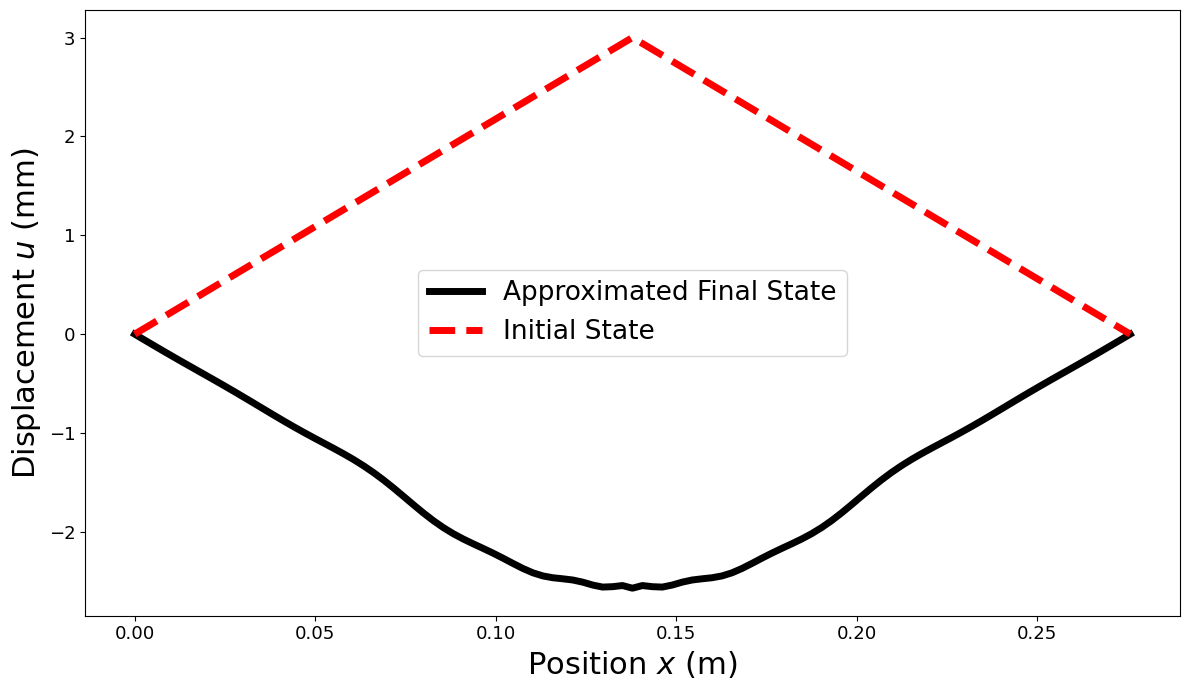

In [26]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringA_noteC, b_stringA_noteC, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringA_noteC, x_stringA_noteC = wave_approximation(a_stringA_noteC, b_stringA_noteC, c_A, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringA_noteC, w_stringA_noteC, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringA_noteC, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note C on String A')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

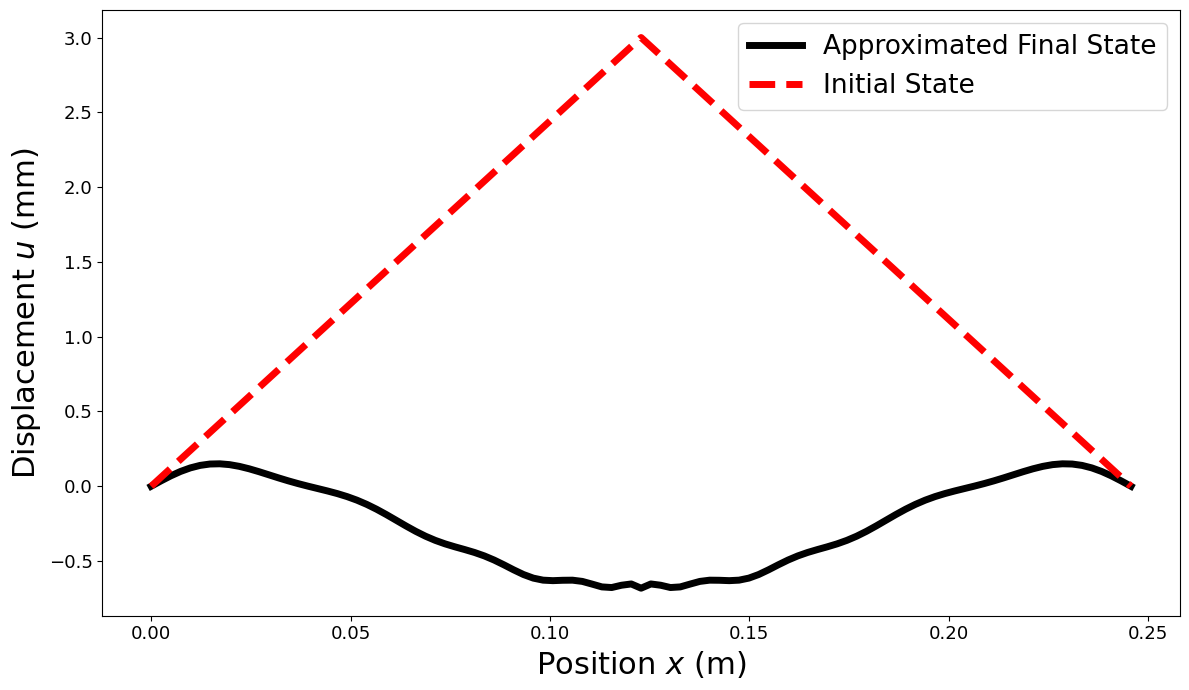

In [27]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringA_noteD, b_stringA_noteD, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringA_noteD, x_stringA_noteD = wave_approximation(a_stringA_noteD, b_stringA_noteD, c_A, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringA_noteD, w_stringA_noteD, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringA_noteD, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note D on String A')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

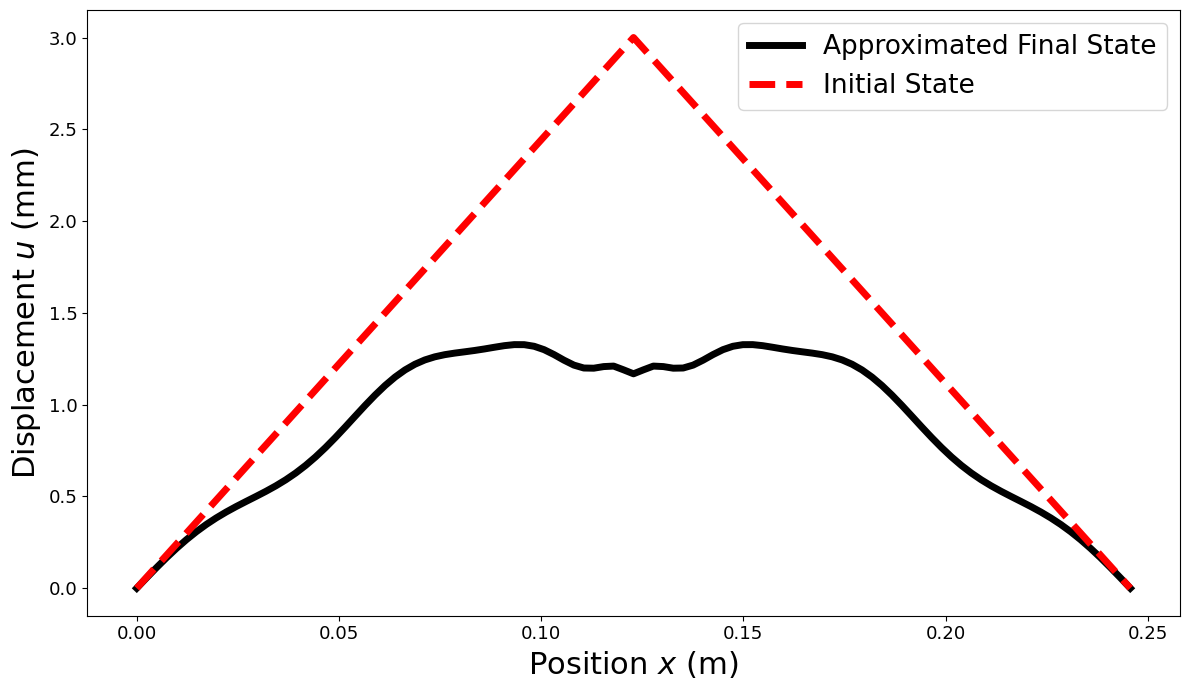

In [28]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringD_noteG, b_stringD_noteG, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringD_noteG, x_stringD_noteG = wave_approximation(a_stringD_noteG, b_stringD_noteG, c_D, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringD_noteG, w_stringD_noteG, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringD_noteG, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note G on String D')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

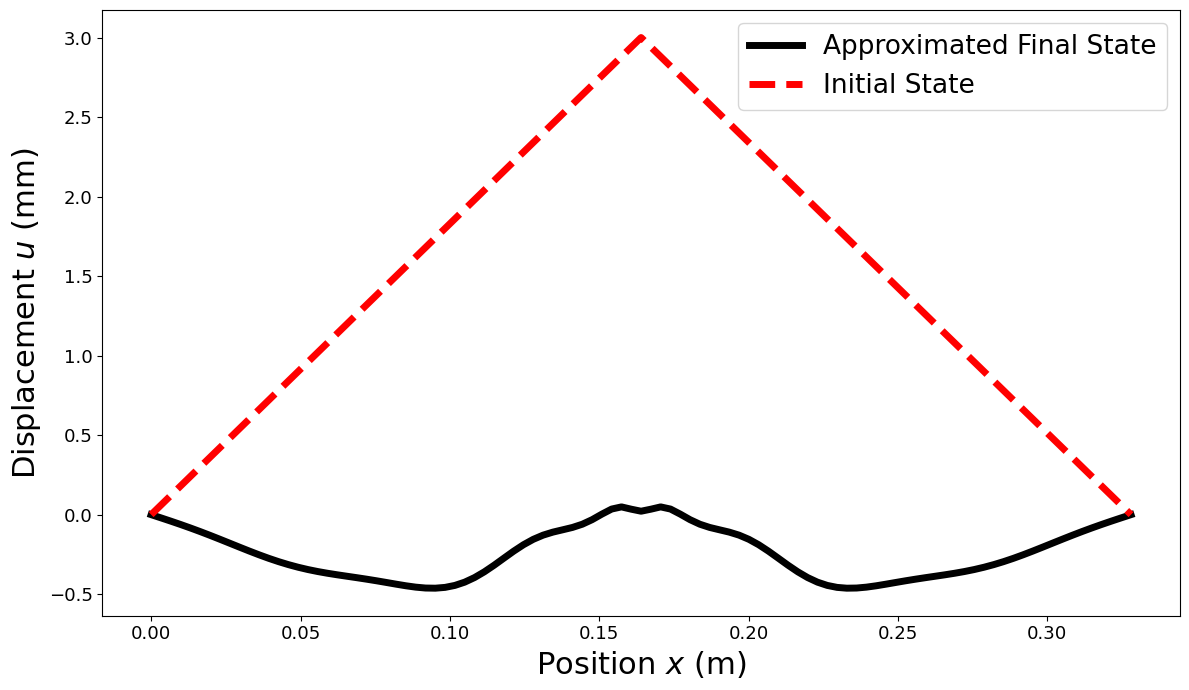

In [29]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringE_noteE, b_stringE_noteE, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringE_noteE, x_stringE_noteE = wave_approximation(a_stringE_noteE, b_stringE_noteE, c_E, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringE_noteE, w_stringE_noteE, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringE_noteE, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note E on String E')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

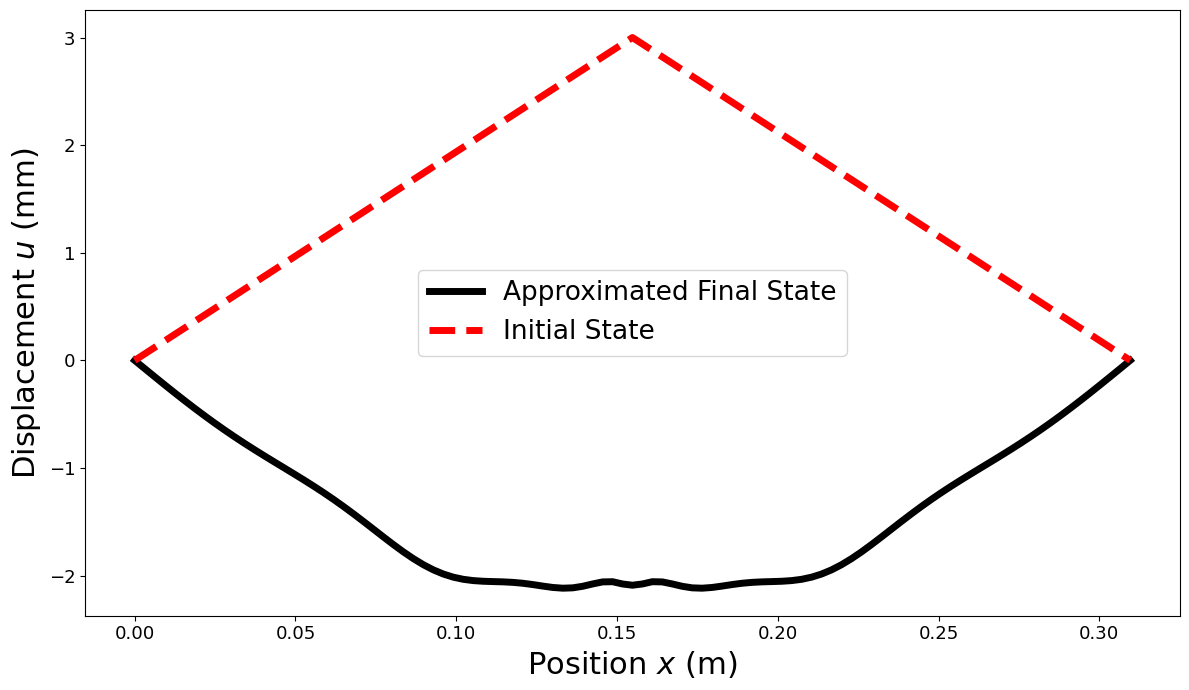

In [30]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringE_noteF, b_stringE_noteF, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringE_noteF, x_stringE_noteF = wave_approximation(a_stringE_noteF, b_stringE_noteF, c_E, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringE_noteF, w_stringE_noteF, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringE_noteF, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note F on String E')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

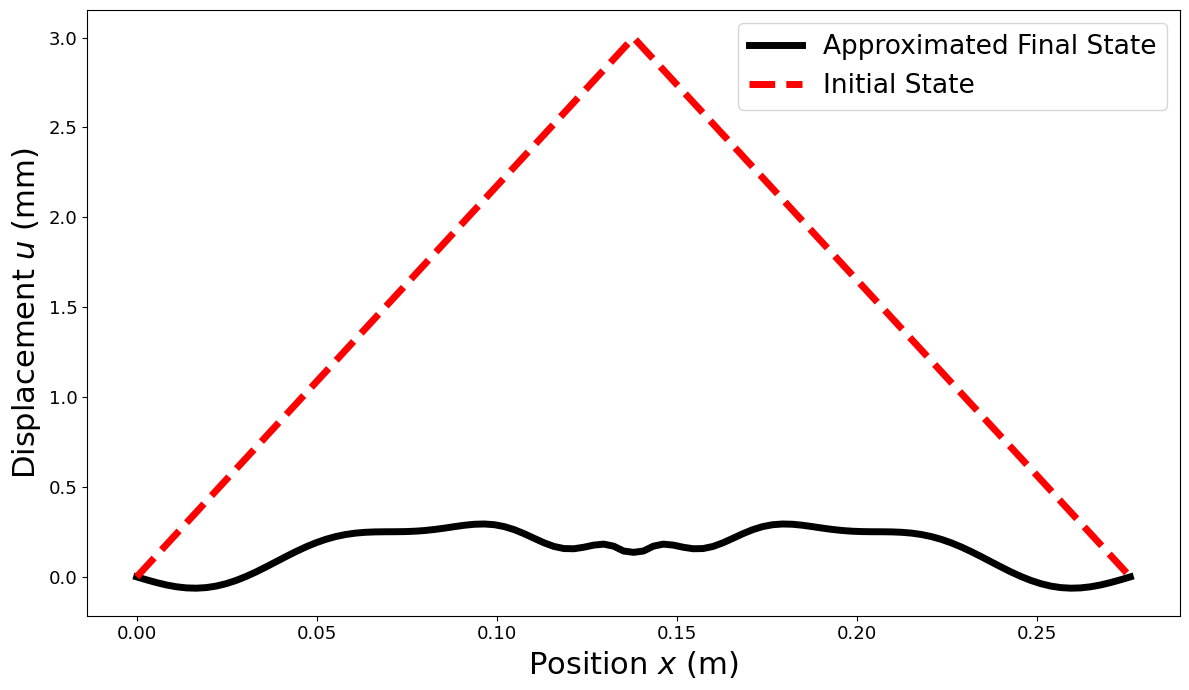

In [31]:
n = 100
delta_t= 0.001
T = 0.1
max_displacement = 3

u_initial = initial_wave_conditions(a_stringE_noteG, b_stringE_noteG, max_displacement)
v_initial = np.zeros(len(u_initial))

w_stringE_noteG, x_stringE_noteG = wave_approximation(a_stringE_noteG, b_stringE_noteG, c_E, n, delta_t, T, u_initial, v_initial)

fig = plt.figure(figsize=(12, 7), tight_layout=True)

ax1 = fig.add_subplot(111)
ax1.plot(x_stringE_noteG, w_stringE_noteG, 'k-', label='Approximated Final State',linewidth=5)
ax1.plot(x_stringE_noteG, u_initial, 'r--', label='Initial State',linewidth=5)
ax1.set_xlabel('Position $x$ (m)',fontsize=22)
ax1.set_ylabel('Displacement $u$ (mm)',fontsize=22)
# ax1.set_title('Note G on String E')
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
ax1.legend(prop={'size': 19})

### Generate GIF of Violin Strings (No Damping)

In [35]:
# Violin string parameters 

c_A = np.sqrt(47.45/(1.28e-3))
c_D = np.sqrt(55.5/(0.67e-3))
c_E = np.sqrt(81.05/(0.43e-3))

a_stringA_noteA = 0
a_stringA_noteB = 0
a_stringA_noteC = 0
a_stringA_noteD = 0

a_stringD_noteG = 0
a_stringE_noteE = 0
a_stringE_noteF = 0
a_stringE_noteG = 0

b_stringA_noteA = 328e-3
b_stringA_noteB = 292.2e-3
b_stringA_noteC = 275.8e-3
b_stringA_noteD = 245.7e-3

b_stringD_noteG = 245.7e-3

b_stringE_noteE = 328e-3
b_stringE_noteF = 309.6e-3
b_stringE_noteG = 275.8e-3

b_list = [b_stringA_noteA, b_stringA_noteB, b_stringA_noteC, b_stringA_noteD, b_stringD_noteG, b_stringE_noteE, b_stringE_noteF, b_stringE_noteG]
c_list = [c_A, c_A, c_A, c_A, c_D, c_E, c_E, c_E]

gif_name_list = ['strA_noteA.gif', 'strA_noteB.gif', 'strA_noteC.gif', 'strA_noteD.gif', 'strD_noteG.gif', 'strE_noteE.gif', 'strE_noteF.gif', 'strE_noteG.gif']

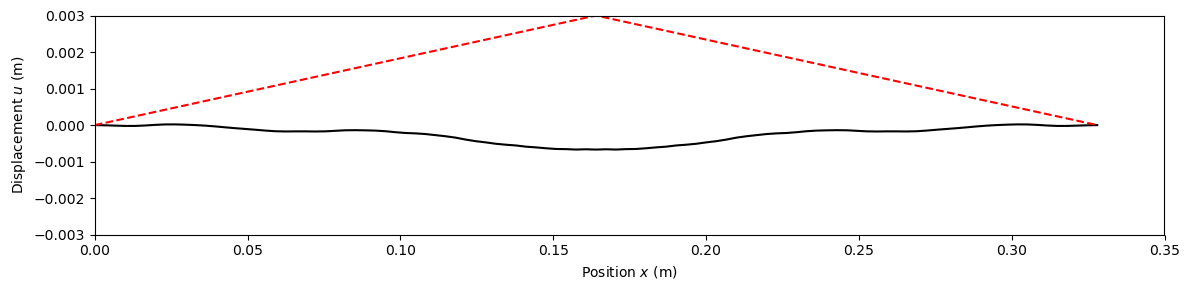

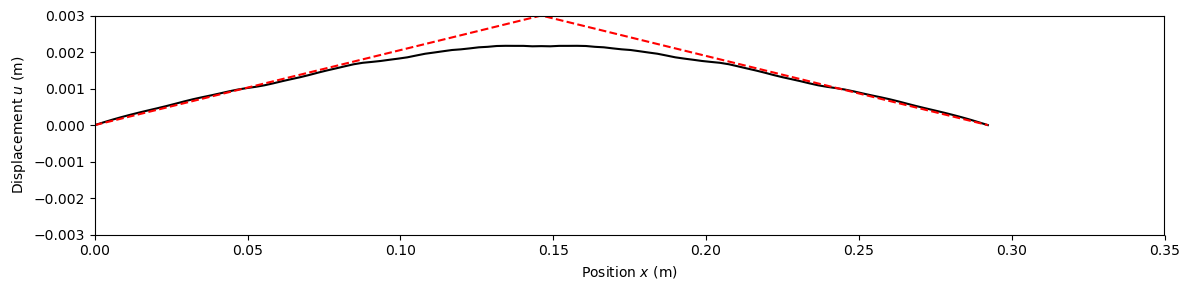

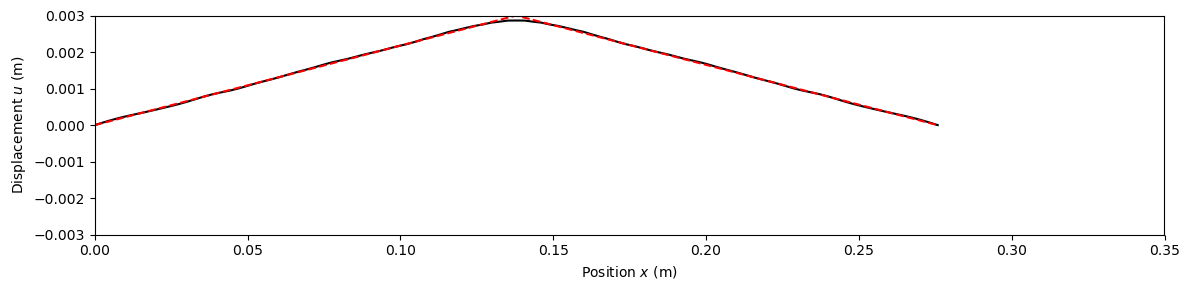

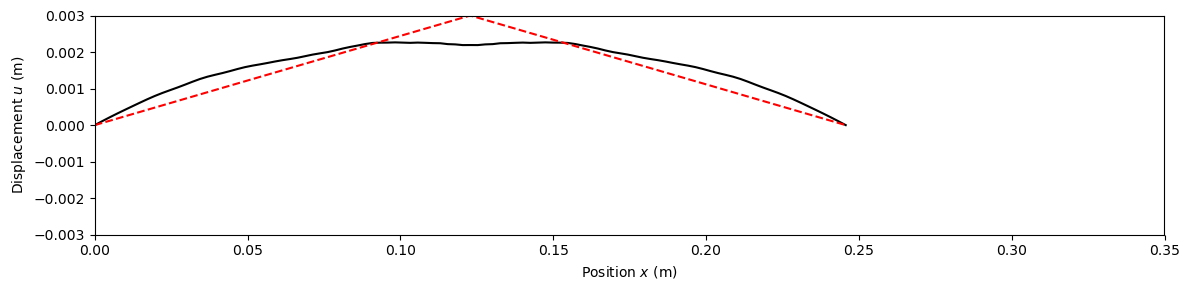

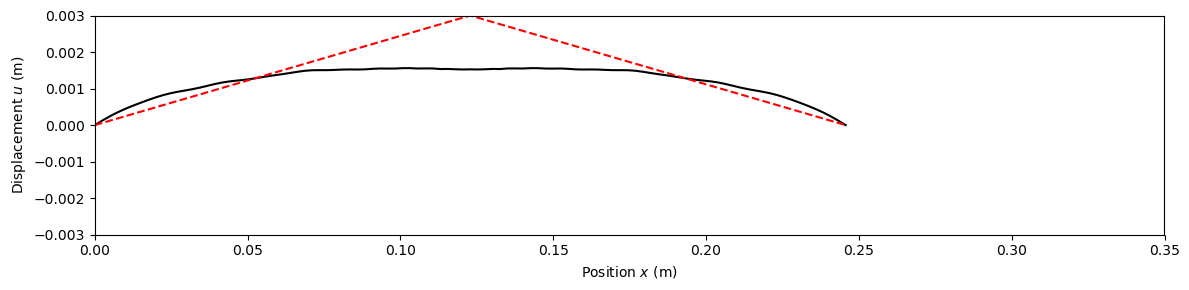

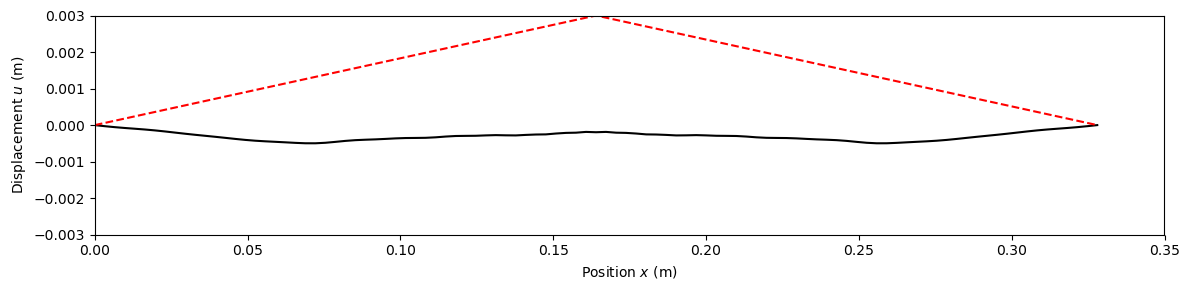

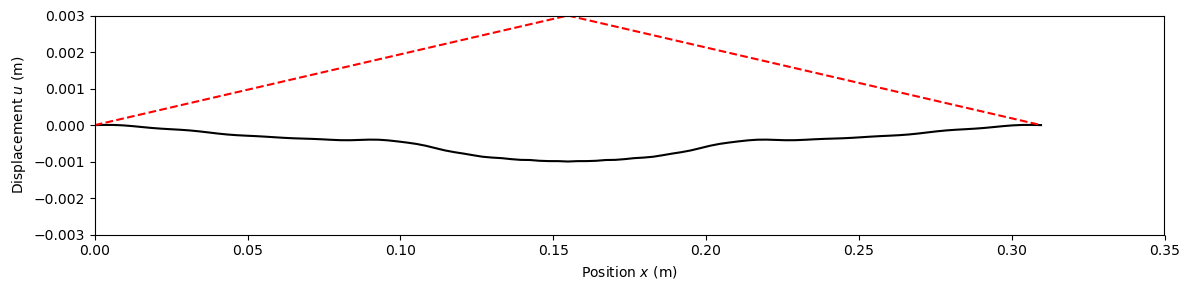

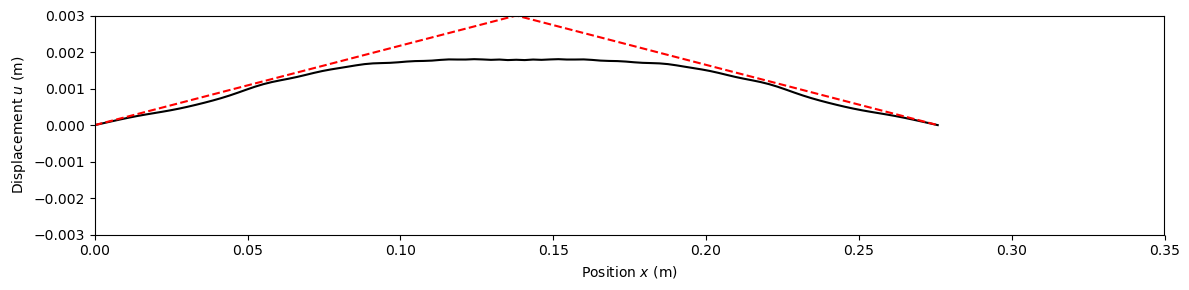

In [71]:
import matplotlib.animation as animation

# Simulation parameters
n = 100
delta_t= 0.001

T_list = np.arange(0, 1, 0.010)
max_displacement = 0.003 # in meters

for i in range(0, 8):
    gif_name = gif_name_list[i]
    a = 0 
    b = b_list[i]
    c = c_list[i]
    # initialize an empty array
    u_final_list = []

    u_initial = initial_wave_conditions(a, b, max_displacement)
    
    for T in T_list:
        u_final, x_list = wave_approximation(a, b, c, n, delta_t, T, u_initial, v_initial)
        u_final_list.append(u_final)
        
    fig = plt.figure(figsize=(12, 3), tight_layout=True)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Position $x$ (m)')
    ax.set_ylabel('Displacement $u$ (m)')
    line, = ax.plot(x_list, u_final, 'k-', label='$u$')
    line2, = ax.plot(x_list, u_initial, 'r--', label=r'$\bar{u}$')
    plt.xlim([0, 0.35])
    plt.ylim([-1*max_displacement, max_displacement])

    def animation_of_wave_equation(k):
        line.set_ydata(u_final_list[k]) 
        line2.set_ydata(u_initial)  
        return line,

    ani = animation.FuncAnimation(fig, animation_of_wave_equation, interval=10, blit=True, save_count=len(T_list))

    writergif = animation.PillowWriter(fps=30)
    ani.save(gif_name,writer=writergif)

### Generate GIF of the A String (With Damping)

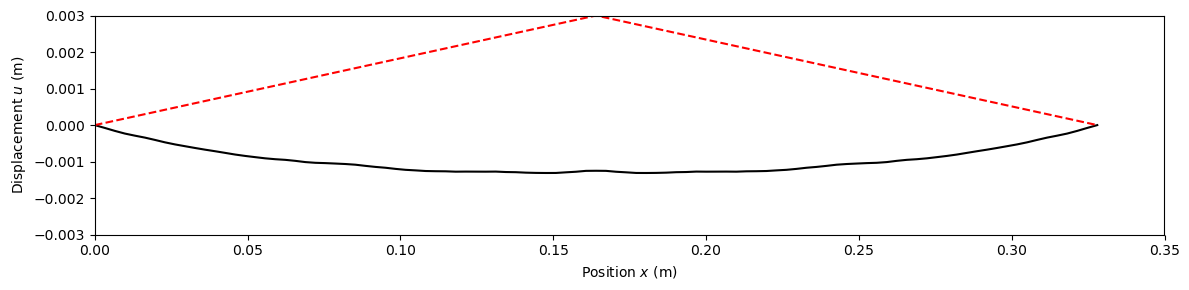

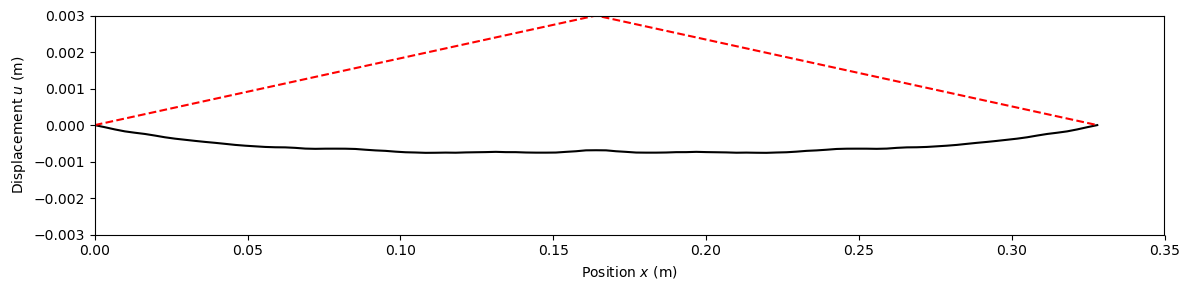

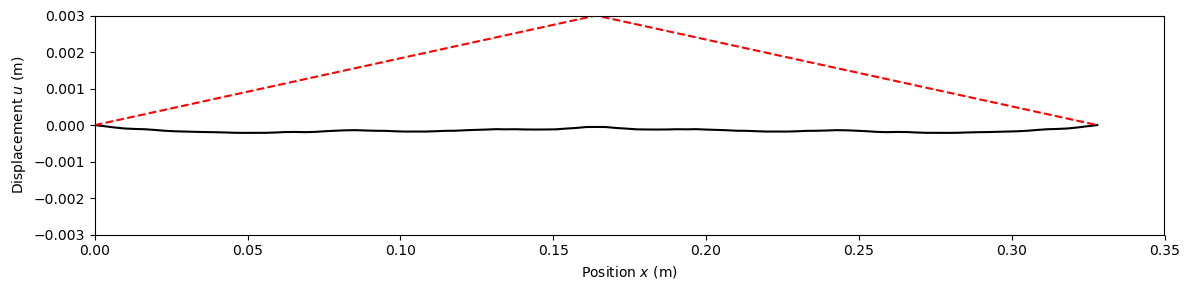

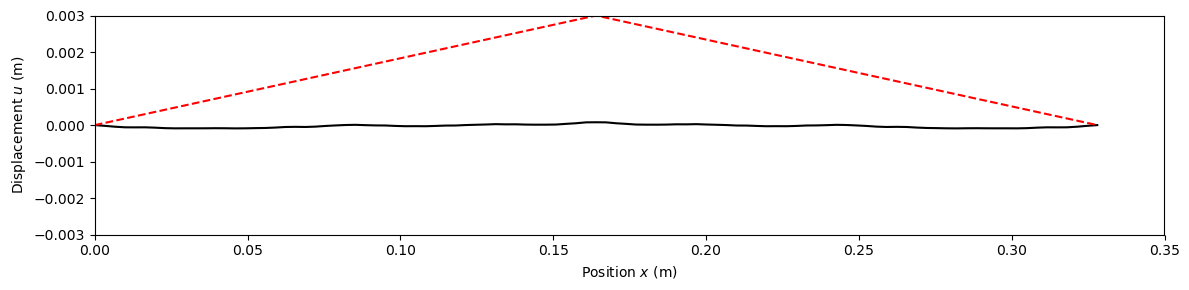

In [43]:
import matplotlib.animation as animation

# Simulation parameters
n = 100
delta_t= 0.001
nu_list = [1, 2, 5, 10]

T_list = np.arange(0, 2, 0.100)
max_displacement = 0.003 # in meters

for nu in nu_list:
    gif_name = 'nu = ' + str(nu) + ' ' + gif_name_list[0]
    a = 0 
    b = b_list[0]
    c = c_list[0]

    # initialize an empty array
    u_final_list = []

    u_initial = initial_wave_conditions(a, b, max_displacement)
    
    for T in T_list:
        u_final, x_list = wave_approximation(a, b, c, n, delta_t, T, u_initial, v_initial, nu)
        u_final_list.append(u_final)
        
    fig = plt.figure(figsize=(12, 3), tight_layout=True)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Position $x$ (m)')
    ax.set_ylabel('Displacement $u$ (m)')
    line, = ax.plot(x_list, u_final, 'k-', label='$u$')
    line2, = ax.plot(x_list, u_initial, 'r--', label=r'$\bar{u}$')
    plt.xlim([0, 0.35])
    plt.ylim([-1*max_displacement, max_displacement])

    def animation_of_wave_equation(k):
        line.set_ydata(u_final_list[k]) 
        line2.set_ydata(u_initial)  
        return line,

    ani = animation.FuncAnimation(fig, animation_of_wave_equation, interval=2000, blit=True, save_count=len(T_list))

    writergif = animation.PillowWriter(fps=30)
    ani.save(gif_name,writer=writergif) 